# Redes Neuronales Recurrentes

A lo largo de este notebook de prácticas haremos varios ejemplos, tanto con RNNs básicas como con LSTMs, y veremos las diferencias.

También trabajaremos con problemas con una única variable y con problemas multivariantes.

# 2. Predicción del valor de acciones en bolsa

A continuación vamos a ver un ejemplo más real y complejo, que además nos va a servir para introducir los problemas multivariantes.

Nos vamos a conectar a la API de Yahoo Stocks para descargarnos los últimos 20 años de datos de la cotización en bolsa de Amazon e intentar predecir valores futuros.

In [1]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install yfinance

                                              0.0/109.5 kB ? eta -:--:--
     -----------------------------------    102.4/109.5 kB 2.0 MB/s eta 0:00:01
     -------------------------------------- 109.5/109.5 kB 2.1 MB/s eta 0:00:00


                                              0.0/60.3 kB ? eta -:--:--
     ---------------------------------------- 60.3/60.3 kB 3.1 MB/s eta 0:00:00
                                              0.0/2.6 MB ? eta -:--:--
     --                                       0.2/2.6 MB 5.3 MB/s eta 0:00:01
     ------                                   0.4/2.6 MB 5.5 MB/s eta 0:00:01
     ----------                               0.7/2.6 MB 6.0 MB/s eta 0:00:01
     -------------                            0.9/2.6 MB 5.8 MB/s eta 0:00:01
     ---------------------                    1.4/2.6 MB 6.8 MB/s eta 0:00:01
     -----------------------                  1.5/2.6 MB 6.9 MB/s eta 0:00:01
     --------------------------               1.7/2.6 MB 6.1 MB/s eta 0:00:01
     --------------------------------         2.1/2.6 MB 6.8 MB/s eta 0:00:01
     ---------------------------------------  2.6/2.6 MB 6.9 MB/s eta 0:00:01
     ---------------------------------------- 2.6/2.6 MB 6.7 MB/s eta 0:00:

In [2]:
import numpy as np
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

dataset_raw = pdr.get_data_yahoo("TSLA", start="2000-01-01", end="2023-05-12")
dataset_raw.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


### **Ejercicio 4**

Trata de predecir el valor de cierre del precio de la acción de Tesla con la mayor exactitud posible. Para ello, puedes emplear tanto RNN como LSTM, elegir el número de celdas, el número de neuronas por celda, y el tamaño de ventana que consideres oportuno. También puedes elegir si quieres rellenar con 0's o no.

**NOTA**: Si decides emplear varias celdas, tienes que devolver las "secuencias" en las celdas que conectan con subsiguientes celdas. Aquí tienes un ejemplo:

```
model = Sequential()
model.add(SimpleRNN(64, input_shape=(look_back, variables), return_sequences=True)) # celda 1, 64 neuronas
model.add(SimpleRNN(32, return_sequences=True)) # celda 2, 32 neuronas
model.add(SimpleRNN(16)) # celda 3, 16 neuronas
model.add(Dense(8,activation='tanh')) # capa densa con 8 neuronas y activación tanh
model.add(Dense(1,activation='linear')) # capa de salida con 1 neurona y activación lineal
```

Para quedarte con la variable correspondiente al valor de cierre de la acción, puedes hacer lo siguiente:

```
dataframe = dataset_raw[['Close']]
```

**Es importante tener en cuenta que no por tener más capas va a funcionar mejor, ya que muy posiblemente ocasionemos overfitting.**

In [3]:
# Nos quedamos con la variable 'Close' unicamente
dataframe = dataset_raw[['Close']]
dataframe.head()

,Close
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000


En esta solución propuesta vamos a ver un ejemplo donde utilizaremos una única celda LSTM con 10 neuronas, 1 único timestamp y no rellenaremos con ceros.

(2168, 1) (2168,)
(1068, 1) (1068,)
(2168, 1, 1)
(1068, 1, 1)
Epoch 1/100
2168/2168 [==============================] - 3s 883us/step - loss: 9.8492e-05
Epoch 2/100
2168/2168 [==============================] - 2s 884us/step - loss: 1.4857e-06
Epoch 3/100
2168/2168 [==============================] - 2s 896us/step - loss: 2.0307e-06
Epoch 4/100
2168/2168 [==============================] - 2s 893us/step - loss: 1.9542e-06
Epoch 5/100
2168/2168 [==============================] - 2s 895us/step - loss: 1.9359e-06
Epoch 6/100
2168/2168 [==============================] - 2s 909us/step - loss: 2.1262e-06
Epoch 7/100
2168/2168 [==============================] - 2s 883us/step - loss: 2.0264e-06
Epoch 8/100
2168/2168 [==============================] - 2s 901us/step - loss: 1.9167e-06
Epoch 9/100
2168/2168 [==============================] - 2s 886us/step - loss: 1.8594e-06
Epoch 10/100
2168/2168 [==============================] - 2s 872us/step - loss: 1.8910e-06
Epoch 11/100
2168/2168 [=============

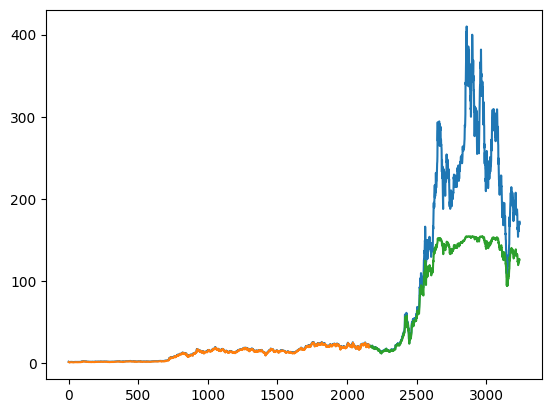

In [4]:
# utilizamos la función create_dataset que NO introduce T 0's iniciales
def create_dataset(dataset, look_back_memory=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back_memory-1):
        dataX.append(dataset[i:i+look_back_memory, 0])
        dataY.append(dataset[i+look_back_memory, 0])
    return numpy.array(dataX), numpy.array(dataY)

# hacemos el import de todo lo que utilizaremos
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fijamos la semilla para obtener resultados reproducibles
numpy.random.seed(42)

# cargamos los datos
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalizamos el dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# dividimos en train y test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# transformamos los datos para crearnos N registros con T timestamps cada uno 
# (uno por cada instante temporal hasta completar el tamaño de la ventana) y 
# las V variables de las que disponga nuestro dataset. En este caso, vamos a 
# escoger una ventana con un único timestamp T=1 y solo tendremos una variable,
# con lo que V=1 (valor de cierre de la acción).
look_back_memory = 1
trainX, trainY = create_dataset(train, look_back_memory)
testX, testY = create_dataset(test, look_back_memory)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

# Nos aseguramos de que las dimensiones de las entradas son las correctas:
# (número de ventanas de T elementos, los T elementos de cada ventana, las V variables de cada timestamp)
variables = 1 # (trainX.shape[1])
trainX = numpy.reshape(trainX, (trainX.shape[0], look_back_memory, variables))
testX = numpy.reshape(testX, (testX.shape[0], look_back_memory, variables))
print(trainX.shape)
print(testX.shape)

# creamos el modelo y lo entrenamos
model = Sequential() #initialize model
model.add(LSTM(10, input_shape=(look_back_memory, variables)))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

# vamos a ver qué tal funciona nuestro modelo
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# una vez hechas las predicciones, tenemos que des-normalizarlas
trainPredict = scaler.inverse_transform(trainPredict)
trainY_orig = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_orig = scaler.inverse_transform([testY])

# y ahora calculamos el error cometido en train y en test
trainScore = math.sqrt(mean_squared_error(trainY_orig[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# por como creamos el dataset de entrenamiento, ahora tenemos que desplazar
# nuestras predicciones para que "cuadren" con el eje x de los datos originales
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back_memory:len(trainPredict)+look_back_memory, :] = trainPredict

# y lo mismo para el test
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back_memory*2)+1:len(dataset)-1, :] = testPredict

# y mostramos los datos originales, la predicción en training y la predicción en test
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Predicción con más de una variable

En esta ocasión utilizaremos todos los datos que nos brinda la API de Yahoo para predecir el precio de cierre de una acción.

In [ ]:
import numpy as np
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

dataset_raw = pdr.get_data_yahoo("TSLA", start="2000-01-01", end="2023-05-12")
dataset_raw.head()

In [ ]:
# ligeramente modificada para escoger la variable objetivo
def create_dataset(dataset, look_back_memory=1, idx_target=-1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back_memory-1):
        dataX.append(dataset[i:i+look_back_memory])
        dataY.append(dataset[i+look_back_memory, idx_target])
    return np.array(dataX), np.array(dataY)

Si quisieramos utilizar solo 1 timestamp y nuestra variable objetivo fuese 'Close' (idx=3):

In [ ]:
X, Y = create_dataset(dataset_raw.values, look_back_memory=1, idx_target=3)
print(X.shape)
print(Y.shape)

(3238, 1, 6)
(3238,)


Fíjate como en este caso deberías tener dimensiones (N, 1, 6), pues estamos cogiendo las 6 variables.

Pero como hemos visto, funciona mejor con una ventana más amplia. Hagámoslo con 10 timestamps y así podremos compararlo luego con el caso de una sola variable y 10 timestamps que acabamos de hacer:

In [ ]:
# Aquí tu código
# X, Y = create_dataset(..., ..., ...)
print(X.shape)
print(Y.shape)

(3229, 10, 6)
(3229,)


In [ ]:
# hacemos el import de todo lo que utilizaremos
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fijamos la semilla para obtener resultados reproducibles
numpy.random.seed(42)

In [ ]:
dataset_raw.shape

(3240, 6)

In [ ]:
dataset_raw.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3.240000e+03
mean,62.045962,63.443428,60.514169,62.011420,62.011420,9.541709e+07
std,96.292052,98.507887,93.803739,96.182335,96.182335,8.156114e+07
min,1.076000,1.108667,0.998667,1.053333,1.053333,1.777500e+06
25%,9.550167,9.722333,9.307500,9.564833,9.564833,4.370738e+07
50%,16.508000,16.736000,16.309999,16.514667,16.514667,7.758900e+07
75%,38.063000,38.929999,37.065167,37.837666,37.837666,1.211697e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


Eliminamos la columna Adj Close, ya que es muy similar a Close.

In [ ]:
dataframe = dataset_raw.drop(columns=['Adj Close'])
dataframe.describe()

,Open,High,Low,Close,Volume
count,3240.000000,3240.000000,3240.000000,3240.000000,3.240000e+03
mean,62.045962,63.443428,60.514169,62.011420,9.541709e+07
std,96.292052,98.507887,93.803739,96.182335,8.156114e+07
min,1.076000,1.108667,0.998667,1.053333,1.777500e+06
25%,9.550167,9.722333,9.307500,9.564833,4.370738e+07
50%,16.508000,16.736000,16.309999,16.514667,7.758900e+07
75%,38.063000,38.929999,37.065167,37.837666,1.211697e+08
max,411.470001,414.496674,405.666656,409.970001,9.140820e+08


In [ ]:
# normalizamos el dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataframe)

Comprobamos que efectivamente está normalizado entre 0 y 1:

In [ ]:
dataset.min(axis=0)

array([0., 0., 0., 0., 0.])

In [ ]:
dataset.max(axis=0)

array([1., 1., 1., 1., 1.])

Tened en cuenta que, a la hora de hacer las predicciones, des-normalizaremos el valor de Close utilizando su mínimo y su máximo.

In [ ]:
# dividimos en train y test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [ ]:
# transformamos los datos para crearnos N registros con T timestamps cada uno 
# (uno por cada instante temporal hasta completar el tamaño de la ventana) y 
# las V variables de las que disponga nuestro dataset. En este caso, vamos a 
# escoger una ventana con un único timestamp T=1 y solo tendremos una variable,
# con lo que V=10 (número de pasajeros).
look_back_memory = 10
trainX, trainY = create_dataset(train, look_back_memory)
testX, testY = create_dataset(test, look_back_memory)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

En este caso, vamos a usar las 5 variables de las que disponemos:
- Open 	
- High
- Low
- Close 
- Volume

De T instantes anteriores, para predecir la variable `Close` en el instante siguiente.

In [ ]:
# Nos aseguramos de que las dimensiones de las entradas son las correctas:
# (número de ventanas de T elementos, los T elementos de cada ventana, las V variables de cada timestamp)

variables = ## Aquí tu código ## Debes introducir el número de variables a utilizar por el modelo

trainX = np.reshape(trainX, (trainX.shape[0], look_back_memory, variables))
testX = np.reshape(testX, (testX.shape[0], look_back_memory, variables))
print(trainX.shape)
print(testX.shape)

In [ ]:
# creamos el modelo y lo entrenamos

# Aquí tu código
# ten en cuenta que ahora hay 5 variables a la hora de especificar el input_shape del modelo
# model = ...
# model.add(...)
# model.add(...)
# model.compile(...)
# model.fit(...)

In [ ]:
# vamos a ver qué tal funciona nuestro modelo
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
# una vez hechas las predicciones, tenemos que des-normalizarlas
xmin = scaler.data_min_[-2]
xmax = scaler.data_max_[-2]
trainPredict = trainPredict * (xmax - xmin) + xmin
trainY_orig = trainY * (xmax - xmin) + xmin
testPredict = testPredict * (xmax - xmin) + xmin
testY_orig = testY * (xmax - xmin) + xmin

In [ ]:
# y ahora calculamos el error cometido en train y en test
trainScore = math.sqrt(mean_squared_error(trainY_orig, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# por como creamos el dataset de entrenamiento, ahora tenemos que desplazar
# nuestras predicciones para que "cuadren" con el eje x de los datos originales
trainPredictPlot = np.full(dataset.shape[0], np.nan)
trainPredictPlot[look_back_memory:len(trainPredict)+look_back_memory] = trainPredict[:, 0]

# y lo mismo para el test
testPredictPlot = np.full(dataset.shape[0], np.nan)
testPredictPlot[len(trainPredict)+(look_back_memory*2)+1:len(dataset)-1] = testPredict[:, 0]

# y mostramos los datos originales, la predicción en training y la predicción en test
plt.plot(dataset_raw['Close'].values)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

**Más ejemplos interesantes de predicción con LSTMs**

- Predicción de potencia consumida en un hogar: 

https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/

https://databricks.com/blog/2019/09/10/doing-multivariate-time-series-forecasting-with-recurrent-neural-networks.html

- Predicción del precio de BitCoin: 

https://medium.com/@pierre.beaujuge/multivariate-time-series-forecasting-with-a-bidirectional-lstm-building-a-model-geared-to-4f020a160636

-  Predicción de la demanda de bicicletas:

https://curiousily.com/posts/demand-prediction-with-lstms-using-tensorflow-2-and-keras-in-python/


**Más datasets** 

https://archive.ics.uci.edu/ml/index.php

